In [1]:
from pyspark.sql import SparkSession

session = SparkSession.builder.getOrCreate()
context = session.sparkContext
df = session.read.csv("trip_data_small.csv", header=True, inferSchema=True)
df.show(5)

21/09/21 07:46:47 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
21/09/21 07:46:49 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


+--------------------+--------------------+---------+---------+------------------+-------------------+-------------------+---------------+-----------------+-------------+----------------+---------------+-----------------+----------------+
|           medallion|        hack_license|vendor_id|rate_code|store_and_fwd_flag|    pickup_datetime|   dropoff_datetime|passenger_count|trip_time_in_secs|trip_distance|pickup_longitude|pickup_latitude|dropoff_longitude|dropoff_latitude|
+--------------------+--------------------+---------+---------+------------------+-------------------+-------------------+---------------+-----------------+-------------+----------------+---------------+-----------------+----------------+
|89D227B655E5C82AE...|BA96DE419E711691B...|      CMT|        1|                 N|2013-01-01 15:11:48|2013-01-01 15:18:10|              4|              382|          1.0|      -73.978165|      40.757977|       -73.989838|       40.751171|
|0BD7C8F5BA12B88E0...|9FD8F69F0804BDB55...| 

In [2]:
df.printSchema()

root
 |-- medallion: string (nullable = true)
 |-- hack_license: string (nullable = true)
 |-- vendor_id: string (nullable = true)
 |-- rate_code: integer (nullable = true)
 |-- store_and_fwd_flag: string (nullable = true)
 |-- pickup_datetime: string (nullable = true)
 |-- dropoff_datetime: string (nullable = true)
 |-- passenger_count: integer (nullable = true)
 |-- trip_time_in_secs: integer (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- pickup_longitude: double (nullable = true)
 |-- pickup_latitude: double (nullable = true)
 |-- dropoff_longitude: double (nullable = true)
 |-- dropoff_latitude: double (nullable = true)



In [3]:
df_sel = df.select("medallion", "passenger_count", "trip_distance", "trip_time_in_secs")
df_sel.show(5)

+--------------------+---------------+-------------+-----------------+
|           medallion|passenger_count|trip_distance|trip_time_in_secs|
+--------------------+---------------+-------------+-----------------+
|89D227B655E5C82AE...|              4|          1.0|              382|
|0BD7C8F5BA12B88E0...|              1|          1.5|              259|
|0BD7C8F5BA12B88E0...|              1|          1.1|              282|
|DFD2202EE08F7A8DC...|              2|          0.7|              244|
|DFD2202EE08F7A8DC...|              1|          2.1|              560|
+--------------------+---------------+-------------+-----------------+
only showing top 5 rows



In [4]:
df_flt = df_sel.filter(df["passenger_count"] > 0)
df_flt.stat.corr('trip_distance', 'trip_time_in_secs', method='pearson')

0.8120644986783555

In [5]:
df_flt.stat.corr('trip_time_in_secs', 'passenger_count', method='pearson')

2.09648654467191e-05

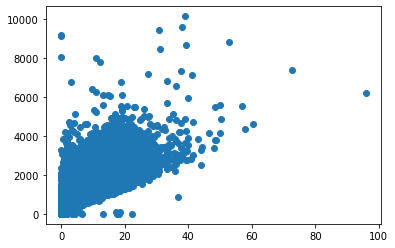

In [6]:
import matplotlib.pyplot as plt
plt.scatter(x='trip_distance', y='trip_time_in_secs', data=df_flt.toPandas())
plt.show()

In [7]:
df_flt.describe().show()

+-------+--------------------+------------------+------------------+------------------+
|summary|           medallion|   passenger_count|     trip_distance| trip_time_in_secs|
+-------+--------------------+------------------+------------------+------------------+
|  count|              598464|            598464|            598464|            598464|
|   mean|                null| 2.123456047481553| 2.853912148433329| 677.2564465030478|
| stddev|                null|1.7245907432998224|3.4224014423072364|479.65369911804737|
|    min|000318C2E3E638158...|                 1|               0.0|                 0|
|    max|FFFECF75AB6CC4FF9...|                 6|             95.85|             10140|
+-------+--------------------+------------------+------------------+------------------+



In [8]:
df_sum = df_flt.groupBy("medallion").sum()
df_sum.show(5)

+--------------------+--------------------+------------------+----------------------+
|           medallion|sum(passenger_count)|sum(trip_distance)|sum(trip_time_in_secs)|
+--------------------+--------------------+------------------+----------------------+
|764CA5AE502C0FEC9...|                   5|               4.4|                  1396|
|80F732B990A7E3763...|                 112|224.51999999999995|                 54660|
|EB6F0753E865DA0AB...|                 184|            394.01|                 62520|
|DB1964B903773868E...|                 137|            257.35|                 65460|
|F0BC746C7DD8C0BC9...|                  98|            294.26|                 67800|
+--------------------+--------------------+------------------+----------------------+
only showing top 5 rows



In [9]:
df_spd =  df_sum.withColumn("average_speeed", df_sum["sum(trip_distance)"] / df_sum["sum(trip_time_in_secs)"])
df_spd.show(5)

+--------------------+--------------------+------------------+----------------------+--------------------+
|           medallion|sum(passenger_count)|sum(trip_distance)|sum(trip_time_in_secs)|      average_speeed|
+--------------------+--------------------+------------------+----------------------+--------------------+
|764CA5AE502C0FEC9...|                   5|               4.4|                  1396|0.003151862464183...|
|80F732B990A7E3763...|                 112|224.51999999999995|                 54660|0.004107574094401756|
|EB6F0753E865DA0AB...|                 184|            394.01|                 62520|0.006302143314139475|
|DB1964B903773868E...|                 137|            257.35|                 65460|0.003931408493736633|
|F0BC746C7DD8C0BC9...|                  98|            294.26|                 67800|0.004340117994100295|
+--------------------+--------------------+------------------+----------------------+--------------------+
only showing top 5 rows



In [10]:
df_sort = df_spd.sort("average_speeed", ascending=False)
df_sort.show(5)

+--------------------+--------------------+------------------+----------------------+-------------------+
|           medallion|sum(passenger_count)|sum(trip_distance)|sum(trip_time_in_secs)|     average_speeed|
+--------------------+--------------------+------------------+----------------------+-------------------+
|C73A20DF6DBD2B384...|                   1|              17.8|                    13| 1.3692307692307693|
|B6AA6EAFD523192F2...|                   1|               4.4|                    20|0.22000000000000003|
|3D2F057C0E0001CFA...|                   1|               6.2|                    34| 0.1823529411764706|
|ED15611F168E41B33...|                   1|               2.3|                    34|0.06764705882352941|
|76BBABBE9C55F5753...|                   1|               1.8|                    29|0.06206896551724138|
+--------------------+--------------------+------------------+----------------------+-------------------+
only showing top 5 rows



In [11]:
df_spd.write.csv("sorted_by_avg_speed.csv")

AnalysisException: path file:/home/jovyan/work/sorted_by_avg_speed.csv already exists.

In [ ]:
session.stop()